# Student Performance Data Experiment 
Semi-synthetic dataset experiment

In [1]:
import sys 
sys.path.append('../..')
import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime

from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

TABLE_NAME = 'logs'

# Import Student Performance Dataset into Notebook
You need to download the [Air Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Air+Quality) dataset from the UCI dataset repository.

In [13]:
dataset = '/home/gridsan/stefanou/data/student-merge.csv'
df = pd.read_csv(dataset)
df.head()

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,famrel.y,freetime.y,goout.y,Dalc.y,Walc.y,health.y,absences.y,G1.y,G2.y,G3.y
0,1,GP,F,15,R,GT3,T,1,1,at_home,...,3,1,2,1,1,1,4,13,13,13
1,2,GP,F,15,R,GT3,T,1,1,other,...,3,3,4,2,4,5,2,13,11,11
2,3,GP,F,15,R,GT3,T,2,2,at_home,...,4,3,1,1,1,2,8,14,13,12
3,4,GP,F,15,R,GT3,T,2,4,services,...,4,3,2,1,1,5,2,10,11,10
4,5,GP,F,15,R,GT3,T,3,3,services,...,4,2,1,2,3,3,2,13,13,13


The first thing that we want to do is check if there are any columns with NaN values in the dataframe.

In [14]:
nan_values = aq_df.isna()
nan_columns = nan_values.any()

columns_with_nan = aq_df.columns[nan_columns].tolist()
print(columns_with_nan)

[]


# Data Exploration

# Create Correlation Matrix
Create a correlation matrix to see which features are correlated to air quality data collection.

In [16]:
corr_matrix = df.corr()
corr_matrix

,Unnamed: 0,age,Medu,Fedu,traveltime.x,studytime.x,failures.x,famrel.x,freetime.x,goout.x,...,famrel.y,freetime.y,goout.y,Dalc.y,Walc.y,health.y,absences.y,G1.y,G2.y,G3.y
Unnamed: 0,1.000000,0.547105,0.015841,-0.010516,0.161020,-0.241849,0.063264,0.025469,0.155397,0.104065,...,0.035359,0.168186,0.118683,0.236924,0.253118,0.045856,0.007416,-0.205348,-0.175041,-0.209595
age,0.547105,1.000000,-0.120663,-0.127846,0.102608,-0.012225,0.153033,0.025451,0.004882,0.159631,...,0.029286,0.016797,0.166931,0.131928,0.156795,-0.066906,0.086303,-0.109549,-0.042010,-0.067977
Medu,0.015841,-0.120663,1.000000,0.649797,-0.205895,0.050040,-0.230169,0.011913,0.035366,0.066870,...,0.007279,0.014831,0.046280,0.038862,-0.016006,-0.033347,0.023040,0.205381,0.215948,0.203554
Fedu,-0.010516,-0.127846,0.649797,1.000000,-0.187856,-0.003824,-0.245386,0.013003,-0.007420,0.033179,...,0.009061,-0.026150,0.013843,0.013747,0.000440,0.023192,0.020829,0.157978,0.184825,0.172009
traveltime.x,0.161020,0.102608,-0.205895,-0.187856,1.000000,-0.101530,0.113276,-0.019759,-0.025226,0.029932,...,-0.009415,-0.015065,0.050244,0.163880,0.137999,0.004489,0.020235,-0.186061,-0.183894,-0.153973
studytime.x,-0.241849,-0.012225,0.050040,-0.003824,-0.101530,1.000000,-0.198990,0.039674,-0.131549,-0.053359,...,0.026456,-0.144890,-0.067147,-0.186246,-0.241411,-0.078421,-0.151648,0.247059,0.265147,0.272130
failures.x,0.063264,0.153033,-0.230169,-0.245386,0.113276,-0.198990,1.000000,-0.067605,0.092117,0.125573,...,-0.065743,0.096531,0.136226,0.126314,0.147968,0.084741,0.187251,-0.306097,-0.369433,-0.383864
famrel.x,0.025469,0.025451,0.011913,0.013003,-0.019759,0.039674,-0.067605,1.000000,0.161720,0.079477,...,0.970334,0.128066,0.036950,-0.096531,-0.122828,0.087705,-0.052550,-0.011597,0.021321,0.045309
freetime.x,0.155397,0.004882,0.035366,-0.007420,-0.025226,-0.131549,0.092117,0.161720,1.000000,0.294310,...,0.139959,0.974424,0.281091,0.193291,0.139365,0.070069,0.028592,-0.090973,-0.113247,-0.108958
goout.x,0.104065,0.159631,0.066870,0.033179,0.029932,-0.053359,0.125573,0.079477,0.294310,1.000000,...,0.049689,0.287391,0.936608,0.262964,0.400458,-0.044195,0.112995,-0.095997,-0.128927,-0.118224


In [57]:
X, y = Tensor(df['freetime.x'].to_numpy())[...,None], Tensor(df['absences.x'].to_numpy())[...,None]

First, let's take see if there is a linear relationship between solar.R and Ozone.

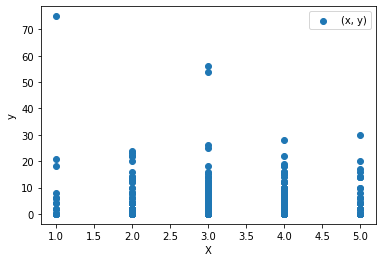

ground-truth variance:  58.00590515136719


In [58]:
data = ch.linspace(0, 175, 100).reshape(100, 1)

ols = LinearRegression()
ols.fit(X, y)
gt_var = (y - ols.predict(X)).var(0)

ax = plt.subplot(1, 1, 1)
# plt.plot(data, ols.predict(data), color='r', label='gt')
plt.scatter(X, y, label='(x, y)')
# plt.scatter(data, Tensor(ols.predict(data)) + ch.sqrt(gt_var)*ch.randn(data.shape[0], 1), color='g', alpha = .5, label='noised gt')
ax.set_xlabel('X')
ax.set_ylabel('y')
plt.legend()
plt.show()

print('ground-truth variance: ', float(gt_var))

# Truncate Regression


alpha:  0.14659685863874344


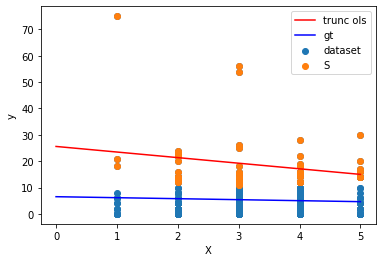

In [59]:
phi = oracle.Left(10.0)
indices = phi(y).eq(1).flatten()

x_trunc, y_trunc = X[indices], y[indices]
alpha = y_trunc.size(0) / y.size(0)
print("alpha: ", alpha)
trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)

data = ch.linspace(0, 5.0, 100)[...,None]

ax = plt.subplot(1, 1, 1)
plt.scatter(X, y, label='dataset')
plt.scatter(x_trunc, y_trunc, label='S')
plt.plot(data, trunc_ols.predict(data), color='red', label='trunc ols')
plt.plot(data, ols.predict(data), color='blue', label='gt')
ax.set_xlabel('X')
ax.set_ylabel('y')
plt.legend()
plt.show()

# Data Preprocessing
We will now use our algorithms to try to correct for this bias.

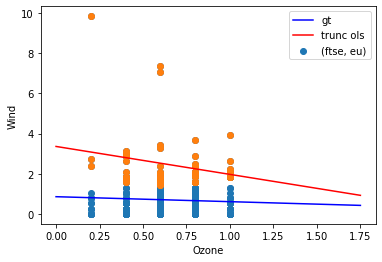

In [60]:
# scale wind by actual noise variance
y_trunc_scaled = y_trunc / ch.sqrt(gt_var)
y_scaled = y / ch.sqrt(gt_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
x_trunc_norm = x_trunc / beta
x_norm = X / beta

scaled_ols = LinearRegression()
scaled_ols.fit(x_norm, y_scaled)

trunc_scaled_ols = LinearRegression()
trunc_scaled_ols.fit(x_trunc_norm, y_trunc_scaled)

data = ch.linspace(0, 1.75, 100).reshape(-1, 1)
ax = plt.subplot(1, 1, 1)
plt.scatter(x_norm, y_scaled, label='(ftse, eu)')
plt.scatter(x_trunc_norm, y_trunc_scaled)
plt.plot(data, scaled_ols.predict(data), color='b', label='gt')
plt.plot(data, trunc_scaled_ols.predict(data), color='r', label='trunc ols')
ax.set_xlabel('Ozone')
ax.set_ylabel('Wind')
plt.legend()
plt.show()

Now, we will our truncated regression algorithm with known variance of the truncated regression data.

In [61]:
scaled_phi = oracle.Left(phi.left / ch.sqrt(gt_var))
trunc_reg = TruncatedRegression(phi=scaled_phi, alpha=Tensor([alpha]), bias=True, unknown=False, bs=10, n=100, tol=1e-1, steps=3000, val=int(.1*x_trunc.size(0)))
trunc_reg.fit(x_trunc_norm, y_trunc_scaled)

Iteration: 0.0 | Score: [0.5298510193824768]
Iteration: 1.0 | Score: [0.21085719764232635]
Iteration: 2.0 | Score: [0.1976805180311203]
Iteration: 3.0 | Score: [0.24340040981769562]
Iteration: 4.0 | Score: [0.25566262006759644]
Iteration: 5.0 | Score: [0.24161386489868164]
Iteration: 6.0 | Score: [0.29983311891555786]
Iteration: 7.0 | Score: [0.24176113307476044]
Iteration: 8.0 | Score: [0.2474226951599121]
Iteration: 9.0 | Score: [0.27675455808639526]
Iteration: 10.0 | Score: [0.24101322889328003]
Iteration: 11.0 | Score: [0.2911528944969177]
Iteration: 12.0 | Score: [0.29519593715667725]
Iteration: 13.0 | Score: [0.28539007902145386]
Iteration: 14.0 | Score: [0.2756528854370117]
Iteration: 15.0 | Score: [0.2908077836036682]
Iteration: 16.0 | Score: [0.2958788573741913]
Iteration: 17.0 | Score: [0.25174108147621155]
Iteration: 18.0 | Score: [0.2780158519744873]
Iteration: 19.0 | Score: [0.25174516439437866]
Iteration: 20.0 | Score: [0.2727605402469635]
Iteration: 21.0 | Score: [0.2903

Linear(in_features=1, out_features=1, bias=True)

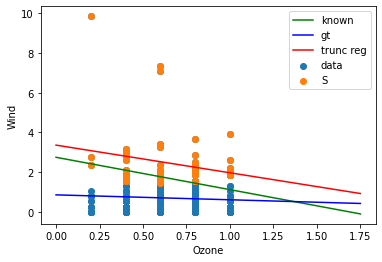

In [56]:
with ch.no_grad():
    plt.scatter(x_norm, y_scaled, label='data')
    plt.scatter(x_trunc_norm, y_trunc_scaled, label='S')
    plt.plot(data, trunc_reg(data), color='green', label='known')
    plt.plot(data, scaled_ols.predict(data), color='blue', label='gt')
    plt.plot(data, trunc_scaled_ols.predict(data), color='red', label='trunc reg')
    plt.xlabel('Ozone')
    plt.ylabel('Wind')
    plt.legend()

emp noise var:  tensor([6.6508])


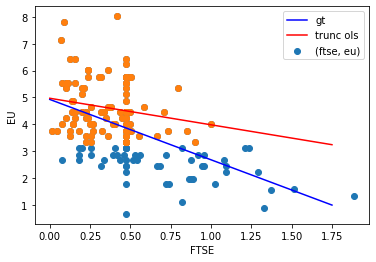

In [283]:
# scale dependent variable by sigma
emp_noise_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print("emp noise var: ", emp_noise_var)

# scale wind by empirical noise variance
y_trunc_emp_scaled = y_trunc / ch.sqrt(emp_noise_var)
y_emp_scaled = y / ch.sqrt(emp_noise_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
x_trunc_norm = x_trunc / beta
x_norm = X / beta

emp_scaled_ols = LinearRegression()
emp_scaled_ols.fit(x_norm, y_emp_scaled)

trunc_emp_scaled_ols = LinearRegression()
trunc_emp_scaled_ols.fit(x_trunc_norm, y_trunc_emp_scaled)

data = ch.linspace(0, 1.75, 100).reshape(-1, 1)
ax = plt.subplot(1, 1, 1)
plt.scatter(x_norm, y_emp_scaled, label='(ftse, eu)')
plt.scatter(x_trunc_norm, y_trunc_emp_scaled)
plt.plot(data, emp_scaled_ols.predict(data), color='b', label='gt')
plt.plot(data, trunc_emp_scaled_ols.predict(data), color='r', label='trunc ols')
ax.set_xlabel('FTSE')
ax.set_ylabel('EU')
plt.legend()
plt.show()

In [284]:
emp_scaled_phi = oracle.Left(phi.left / ch.sqrt(emp_noise_var))
trunc_reg = TruncatedRegression(phi=emp_scaled_phi, alpha=Tensor([alpha]), bias=True, unknown=True, bs=10, n=100, tol=1e-1, steps=2000, val=int(.1*oz_trunc.size(0)))
trunc_reg.fit(x_trunc_norm, y_trunc_emp_scaled)

Iteration: 0.0 | Score: [0.44360026717185974, -2.2167606353759766]
Iteration: 1.0 | Score: [-0.6446093916893005, 2.8146321773529053]
Iteration: 2.0 | Score: [-0.09967663139104843, 0.44850748777389526]
Iteration: 3.0 | Score: [0.2467910200357437, -1.2125564813613892]
Iteration: 4.0 | Score: [0.4630746841430664, -2.2744593620300293]
Iteration: 5.0 | Score: [1.2338148355484009, -6.530020713806152]
Iteration: 6.0 | Score: [-0.2140524685382843, 0.9587422609329224]
Iteration: 7.0 | Score: [0.03776449337601662, -0.20119726657867432]
Iteration: 8.0 | Score: [-0.049427855759859085, 0.19307130575180054]
Iteration: 9.0 | Score: [0.4822569191455841, -2.453150510787964]
Iteration: 10.0 | Score: [0.4231357276439667, -2.1243343353271484]
Iteration: 11.0 | Score: [0.09918344020843506, -0.5395187139511108]
Iteration: 12.0 | Score: [0.13817884027957916, -0.756193995475769]
Iteration: 13.0 | Score: [0.36776259541511536, -1.8650164604187012]
Iteration: 14.0 | Score: [0.6055625677108765, -3.154822587966919

LinearUnknownVariance()

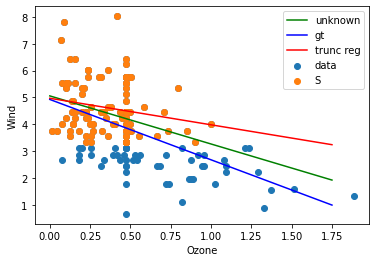

In [285]:
with ch.no_grad():
    plt.scatter(x_norm, y_emp_scaled, label='data')
    plt.scatter(x_trunc_norm, y_trunc_emp_scaled, label='S')
    plt.plot(data, trunc_reg(data), color='green', label='unknown')
    plt.plot(data, emp_scaled_ols.predict(data), color='blue', label='gt')
    plt.plot(data, trunc_emp_scaled_ols.predict(data), color='red', label='trunc reg')
    plt.xlabel('Ozone')
    plt.ylabel('Wind')
    plt.legend()

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [286]:
args = Parameters({
    "bias": True,
    "bs": 10,
    "trials": 100,
    "steps": 1000,
    "out_dir": '/home/gridsan/stefanou/Regression/', 
    "table_name": 'results', 
    'tol': 1e-2,
    'n': 100,
})
EXP = 'AirQuality'
mse_loss = ch.nn.MSELoss()

# Create Store for Experiment Results

In [176]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

# Run Procedure

In [206]:
gt_var

tensor([8.9128])

In [191]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(ozone, wind)
gt_params = Tensor(np.concatenate([gt.coef_, np.expand_dims(gt.intercept_, 0)], axis=1))
gt_var = Tensor(np.var(gt.predict(ozone) - wind.numpy(), 0))

C = [1.0, 2, 2.5, 3, 3.5, 4, 5, 6, 6.5, 7.0, 8.0]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + EXP)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
#         'trunc_reg_param_mse': float, 
#         'trunc_var_l1': float,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Left(c)
        indices = phi(wind).eq(1).flatten()
        x_trunc, y_trunc = ozone[indices], wind[indices]
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.size(0) / ozone.size(0)])
        print("alpha: ", alpha)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        print("ols params: ", ols_params)
        print("gt params: ", gt_params)
        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(wind.flatten(), ols.predict(ozone).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params.flatten()),
        })
        
        val = int(.1*x_trunc.size(0))
        
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
        x_trunc_norm = x_trunc / beta
        
        # scale by the known noise variance 
        y_trunc_scaled = y_trunc / ch.sqrt(gt_var)
        phi_scaled = oracle.Left(phi.left / ch.sqrt(gt_var))
        
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': phi_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with known noise variance using empirical noise variance
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled) 
        
        with ch.no_grad():       
            w, w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) 
            known_params = ch.cat([w.flatten(), w0])
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(wind.flatten(), ozone@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params.flatten()),
                'known_time': total_time, 
            })
            
        
        phi_emp_scaled = oracle.Left(phi.left / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = y_trunc / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled)  
        
        with ch.no_grad():      
            w, w0 = (unknown_trunc_reg.weight * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) * unknown_trunc_reg.variance 
            unknown_params = ch.cat([w, w0]).flatten()
            # known results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(wind.flatten(), ozone@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params.flatten()),
                'unknown_time': total_time, 
                'unknown_var_l1': ch.abs(unknown_trunc_reg.variance * emp_noise_var - gt_var)
            })
            

        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
            
    # close current store
    store.close()

Logging in: /home/gridsan/stefanou/Regression/AirQuality/9db3846d-1128-4c80-b488-05bd4c3eb5ba
alpha:  tensor([1.])
ols params:  tensor([-0.0652, 12.7039])
gt params:  tensor([[-0.0652, 12.7039]])
Iteration: 0.0 | Score: [0.09644844383001328]
Iteration: 1.0 | Score: [0.11379536986351013]
Iteration: 2.0 | Score: [0.09146584570407867]
Iteration: 3.0 | Score: [0.04895583540201187]
Iteration: 4.0 | Score: [0.0071210190653800964]
Iteration: 0.0 | Score: [-0.18954379856586456, 0.6790188550949097]
Iteration: 1.0 | Score: [0.15723848342895508, -0.5712143182754517]
Iteration: 2.0 | Score: [-0.22678431868553162, 0.8314092755317688]
Iteration: 3.0 | Score: [-0.5465685129165649, 1.8951863050460815]
Iteration: 4.0 | Score: [0.2693268358707428, -1.0397220849990845]
Iteration: 5.0 | Score: [-0.08975881338119507, 0.34040749073028564]
Iteration: 6.0 | Score: [-0.19855782389640808, 0.6803900599479675]
Iteration: 7.0 | Score: [-0.14345692098140717, 0.5043009519577026]
Iteration: 8.0 | Score: [-0.077626794

Iteration: 2.0 | Score: [0.33660927414894104, -1.1059517860412598]
Iteration: 3.0 | Score: [-0.1548558473587036, 0.737293541431427]
Iteration: 4.0 | Score: [-0.0008948851027525961, 0.17620481550693512]
Iteration: 5.0 | Score: [0.01255469024181366, 0.12496758252382278]
Iteration: 6.0 | Score: [0.5440989136695862, -1.9664125442504883]
Iteration: 7.0 | Score: [0.4126148819923401, -1.4374372959136963]
Iteration: 8.0 | Score: [0.19856731593608856, -0.564809262752533]
Iteration: 9.0 | Score: [0.3306387960910797, -1.1038143634796143]
Iteration: 10.0 | Score: [0.07363545894622803, -0.13026419281959534]
Iteration: 0.0 | Score: [0.27475398778915405, -1.0851409435272217]
Iteration: 1.0 | Score: [0.13992717862129211, -0.5825761556625366]
Iteration: 2.0 | Score: [0.6193742156028748, -2.443345546722412]
Iteration: 3.0 | Score: [-0.02742133103311062, -0.016316860914230347]
Iteration: 4.0 | Score: [0.26869598031044006, -1.1151485443115234]
Iteration: 5.0 | Score: [0.3840940594673157, -1.57253813743591

Iteration: 5.0 | Score: [0.4646943211555481, -1.8291903734207153]
Iteration: 6.0 | Score: [0.4730321168899536, -1.8756872415542603]
Iteration: 7.0 | Score: [0.3135768473148346, -1.2362128496170044]
Iteration: 8.0 | Score: [0.8106727600097656, -3.3004698753356934]
Iteration: 9.0 | Score: [0.24558277428150177, -0.9833738803863525]
Iteration: 10.0 | Score: [0.9717714786529541, -4.039463043212891]
Iteration: 0.0 | Score: [0.2988484799861908, -1.1245543956756592]
Iteration: 1.0 | Score: [0.07745835185050964, -0.2495671510696411]
Iteration: 2.0 | Score: [-0.15322889387607574, 0.6620206832885742]
Iteration: 3.0 | Score: [0.5102236270904541, -2.02639102935791]
Iteration: 4.0 | Score: [0.9766778349876404, -4.213742733001709]
Iteration: 5.0 | Score: [0.007174776401370764, -0.009682059288024902]
alpha:  tensor([0.8954])
ols params:  tensor([-0.0508, 12.4823])
gt params:  tensor([[-0.0652, 12.7039]])
Iteration: 0.0 | Score: [0.16942664980888367]
Iteration: 1.0 | Score: [0.010658908635377884]
Itera

Iteration: 9.0 | Score: [0.07291340827941895, -0.3887290954589844]
Iteration: 10.0 | Score: [0.15900319814682007, -0.7718372941017151]
Iteration: 0.0 | Score: [0.47714194655418396, -2.278228521347046]
Iteration: 1.0 | Score: [1.153502345085144, -5.792402267456055]
Iteration: 2.0 | Score: [0.03515354543924332, -0.303246408700943]
Iteration: 3.0 | Score: [0.8039630055427551, -3.879667043685913]
Iteration: 4.0 | Score: [0.1420820951461792, -0.7858402729034424]
Iteration: 5.0 | Score: [0.26416417956352234, -1.3398635387420654]
Iteration: 6.0 | Score: [0.6211330890655518, -3.0752830505371094]
Iteration: 7.0 | Score: [0.050369326025247574, -0.4262453317642212]
Iteration: 8.0 | Score: [1.2606319189071655, -6.439657211303711]
Iteration: 9.0 | Score: [0.0353107750415802, -0.39871203899383545]
Iteration: 10.0 | Score: [0.3273734748363495, -1.698574185371399]
alpha:  tensor([0.6471])
ols params:  tensor([-0.0287, 12.8165])
gt params:  tensor([[-0.0652, 12.7039]])
Iteration: 0.0 | Score: [0.056011

Iteration: 9.0 | Score: [0.07509661465883255, -0.5197127461433411]
Iteration: 10.0 | Score: [0.28773462772369385, -1.4082082509994507]
Iteration: 0.0 | Score: [0.10522333532571793, -0.1752428412437439]
Iteration: 1.0 | Score: [-0.3264314532279968, 1.3203375339508057]
Iteration: 2.0 | Score: [-0.07241564244031906, 0.45527225732803345]
Iteration: 3.0 | Score: [0.476922869682312, -1.5777268409729004]
Iteration: 4.0 | Score: [0.7415906190872192, -2.6766510009765625]
Iteration: 5.0 | Score: [0.214742049574852, -0.5955715179443359]
Iteration: 6.0 | Score: [-0.09245432913303375, 0.4929364025592804]
Iteration: 7.0 | Score: [0.146145761013031, -0.3501329720020294]
Iteration: 8.0 | Score: [-0.285611093044281, 1.1273788213729858]
Iteration: 9.0 | Score: [-0.11512543261051178, 0.5783102512359619]
Iteration: 10.0 | Score: [0.2653828263282776, -0.8171193599700928]
alpha:  tensor([0.9869])
ols params:  tensor([-0.0634, 12.7028])
gt params:  tensor([[-0.0652, 12.7039]])
Iteration: 0.0 | Score: [0.4595

Iteration: 2.0 | Score: [-0.27384042739868164, 1.0958284139633179]
Iteration: 3.0 | Score: [0.5657801628112793, -2.0854618549346924]
Iteration: 4.0 | Score: [1.060267448425293, -4.319414138793945]
Iteration: 5.0 | Score: [0.5895907878875732, -2.258544445037842]
Iteration: 6.0 | Score: [0.0014954351354390383, 0.09465604275465012]
Iteration: 7.0 | Score: [0.22861815989017487, -0.75963294506073]
Iteration: 8.0 | Score: [-0.12726342678070068, 0.5347368717193604]
Iteration: 9.0 | Score: [-0.20697133243083954, 0.8449057340621948]
Iteration: 10.0 | Score: [0.21673233807086945, -0.7680527567863464]
Iteration: 0.0 | Score: [0.31841740012168884, -1.2106982469558716]
Iteration: 1.0 | Score: [0.2147253006696701, -0.7237493991851807]
Iteration: 2.0 | Score: [0.10293208062648773, -0.3162018954753876]
Iteration: 3.0 | Score: [1.3877564668655396, -5.987754821777344]
Iteration: 4.0 | Score: [0.0897204652428627, -0.2803143560886383]
Iteration: 5.0 | Score: [0.021271899342536926, -0.015469253063201904]
I

Iteration: 7.0 | Score: [-0.13055413961410522, 0.5088134407997131]
Iteration: 8.0 | Score: [-0.17788071930408478, 0.693107545375824]
Iteration: 9.0 | Score: [-0.197219118475914, 0.786125659942627]
Iteration: 10.0 | Score: [0.22852091491222382, -1.0125045776367188]
Iteration: 0.0 | Score: [0.7666804790496826, -2.8252274990081787]
Iteration: 1.0 | Score: [0.07885836809873581, -0.1686730682849884]
Iteration: 2.0 | Score: [0.5762961506843567, -2.036428451538086]
Iteration: 3.0 | Score: [0.5095050930976868, -1.7701834440231323]
Iteration: 4.0 | Score: [0.4614718556404114, -1.599128246307373]
Iteration: 5.0 | Score: [0.4683491587638855, -1.6293741464614868]
Iteration: 6.0 | Score: [1.3772670030593872, -5.675268173217773]
Iteration: 7.0 | Score: [0.46671420335769653, -1.6578503847122192]
Iteration: 8.0 | Score: [0.763719916343689, -2.8526406288146973]
Iteration: 9.0 | Score: [0.5359848141670227, -1.9079339504241943]
Iteration: 10.0 | Score: [0.6847978234291077, -2.5557610988616943]
alpha:  te

Iteration: 2.0 | Score: [1.4889674186706543, -7.603610038757324]
Iteration: 3.0 | Score: [0.06371485441923141, -0.2723468840122223]
Iteration: 4.0 | Score: [1.085697889328003, -5.378842353820801]
Iteration: 5.0 | Score: [0.5602835416793823, -2.6285650730133057]
Iteration: 6.0 | Score: [0.9216445684432983, -4.498005390167236]
Iteration: 7.0 | Score: [-0.0020255574490875006, -0.021338999271392822]
Iteration: 8.0 | Score: [0.32531023025512695, -1.5156763792037964]
Iteration: 9.0 | Score: [0.4957669973373413, -2.392885684967041]
Iteration: 10.0 | Score: [0.3574424684047699, -1.6899820566177368]
Logging in: /home/gridsan/stefanou/Regression/AirQuality/df290e52-c227-4e83-a100-17991f89a8cb
alpha:  tensor([1.])
ols params:  tensor([-0.0652, 12.7039])
gt params:  tensor([[-0.0652, 12.7039]])
Iteration: 0.0 | Score: [0.20089736580848694]
Iteration: 1.0 | Score: [0.09731356799602509]
Iteration: 2.0 | Score: [0.09249716997146606]
Iteration: 3.0 | Score: [0.005681954324245453]
Iteration: 0.0 | Scor

KeyboardInterrupt: 

# Results

In [182]:
store.close()

In [184]:
reader = CollectionReader(args.out_dir + EXP)
results = reader.df(TABLE_NAME)
results.head()

100%|██████████| 10/10 [00:00<00:00, 125.89it/s]


,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,alpha,c,num_samples,exp_id
0,0.277998,0.000010,0,0.034127,1.011202,0.276445,3,0.281893,0.000000,0.058253,1.000000,1.0,153,86c7b475-e4af-430d-9a87-3c3c058dc8cd
1,0.278144,0.026345,0,0.015193,0.969488,0.259547,2,0.281653,0.001476,0.337258,0.993464,2.0,152,86c7b475-e4af-430d-9a87-3c3c058dc8cd
2,0.276827,0.026245,0,0.314144,0.813266,0.263929,3,0.281247,0.000002,0.334309,0.986928,2.5,151,86c7b475-e4af-430d-9a87-3c3c058dc8cd
3,0.278337,0.010111,1,0.976901,0.982629,0.224470,4,0.280248,0.000297,0.466569,0.980392,3.0,150,86c7b475-e4af-430d-9a87-3c3c058dc8cd
4,0.278994,0.000388,0,0.009324,1.139410,0.231315,2,0.280879,0.000333,0.420097,0.973856,3.5,149,86c7b475-e4af-430d-9a87-3c3c058dc8cd


In [189]:
results.head(15)

,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,alpha,c,num_samples,exp_id
0,0.277998,0.000010,0,0.034127,1.011202,0.276445,3,0.281893,0.000000,0.058253,1.000000,1.0,153,86c7b475-e4af-430d-9a87-3c3c058dc8cd
1,0.278144,0.026345,0,0.015193,0.969488,0.259547,2,0.281653,0.001476,0.337258,0.993464,2.0,152,86c7b475-e4af-430d-9a87-3c3c058dc8cd
2,0.276827,0.026245,0,0.314144,0.813266,0.263929,3,0.281247,0.000002,0.334309,0.986928,2.5,151,86c7b475-e4af-430d-9a87-3c3c058dc8cd
3,0.278337,0.010111,1,0.976901,0.982629,0.224470,4,0.280248,0.000297,0.466569,0.980392,3.0,150,86c7b475-e4af-430d-9a87-3c3c058dc8cd
4,0.278994,0.000388,0,0.009324,1.139410,0.231315,2,0.280879,0.000333,0.420097,0.973856,3.5,149,86c7b475-e4af-430d-9a87-3c3c058dc8cd
5,0.264723,0.023325,0,0.000478,0.750131,0.222308,0,0.280490,0.000005,0.369918,0.967320,4.0,148,86c7b475-e4af-430d-9a87-3c3c058dc8cd
6,0.254123,0.089080,0,1.332225,0.517681,0.200302,2,0.273976,0.002056,0.576487,0.934641,5.0,143,86c7b475-e4af-430d-9a87-3c3c058dc8cd
7,0.250348,0.011384,0,0.059343,0.535562,0.278821,2,0.256005,0.024653,0.611852,0.895425,6.0,137,86c7b475-e4af-430d-9a87-3c3c058dc8cd
8,0.274417,0.144540,0,0.000659,1.632280,0.198839,2,0.217977,0.045553,0.812873,0.843137,6.5,129,86c7b475-e4af-430d-9a87-3c3c058dc8cd
9,0.279306,0.020996,0,0.128093,1.627416,0.258521,2,0.180237,0.002890,1.341405,0.784314,7.0,120,86c7b475-e4af-430d-9a87-3c3c058dc8cd


# Plot Results

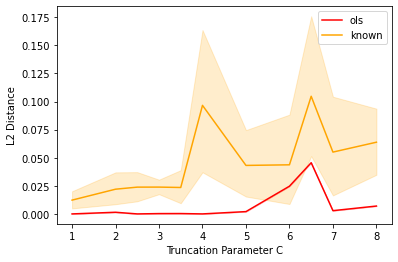

In [203]:
# plot results for regression parameter MSE
# sns.lineplot(data=results, x='c', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results, x='c', y='ols_param_mse', label='ols', color='red')
ax = sns.lineplot(data=results, x='c', y='known_param_mse', label='known', color='orange')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
plt.show()

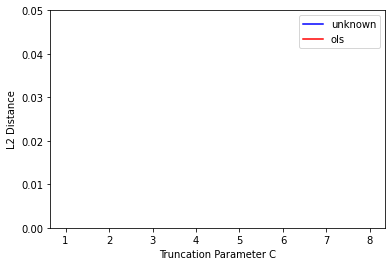

In [187]:
# plot results for regression noise variance MSE
sns.lineplot(data=results, x='c', y='unknown_var_l1', label='unknown', color="blue")
ax = sns.lineplot(data=results, x='c', y='ols_var_l1', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
ax.set(ylim=(0, .05))
plt.show()

In [ ]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(ozone, wind)
gt_params = Tensor(np.concatenate([gt.coef_, np.expand_dims(gt.intercept_, 0)], axis=1))
gt_var = Tensor(np.var(gt.predict(ozone) - wind.numpy(), 0))

C = [1.0, 2, 2.5, 3, 3.5, 4, 5, 6, 6.5, 7.0, 8.0]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + EXP)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
#         'trunc_reg_param_mse': float, 
#         'trunc_var_l1': float,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Left(c)
        indices = phi(wind).eq(1).flatten()
        x_trunc, y_trunc = ozone[indices], wind[indices]
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.size(0) / ozone.size(0)])
        print("alpha: ", alpha)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        
        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(wind.flatten(), ols.predict(ozone).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params.flatten()),
        })
        
        val = int(.1*x_trunc.size(0))
        
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
        x_trunc_norm = x_trunc / beta
        
        # scale by the known noise variance 
        y_trunc_scaled = y_trunc / ch.sqrt(gt_var)
        phi_scaled = oracle.Left(phi.left / ch.sqrt(gt_var))
        
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': phi_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with known noise variance using empirical noise variance
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled) 
        
        with ch.no_grad():       
            w, w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) 
            known_params = ch.cat([w.flatten(), w0])
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(wind.flatten(), ozone@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params.flatten()),
                'known_time': total_time, 
            })
            
        
        phi_emp_scaled = oracle.Left(phi.left / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = y_trunc / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled)  
        
        with ch.no_grad():      
            w, w0 = (unknown_trunc_reg.weight * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) * unknown_trunc_reg.variance 
            unknown_params = ch.cat([w, w0]).flatten()
            # known results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(wind.flatten(), ozone@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params.flatten()),
                'unknown_time': total_time, 
                'unknown_var_l1': ch.abs(unknown_trunc_reg.variance * emp_noise_var - gt_var)
            })
            

        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
            
    # close current store
    store.close()